# Detecting change in urban extent

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual)


## Background

The rate at which cities and towns grow, or the urbanisation rate, is an important indicator of the sustainability of towns and cities. Rapid, unplanned urbanisation can result in poor social, economic, and environmental outcomes due to inadequate and overburdened infrastructure and services creating congestion, worsening air pollution, and leading to a shortage of adequate housing.

The first requirement for addressing the impacts of rapid urbanisation is to accurately and regularly monitor urban expansion in order to track urban development over time. Earth Observation datasets, such as those available through the Digital Earth Africa platform provide a cost-effective and accurate means of mapping the urban extent of cities.  


## Description

This notebook will use Sentinel-2 annual geomedians to examine the change in urban extent between a baseline period and a more recent period.  The difference in urban extent (area is square kilometres) between the two periods is calculated, along with a map highlighting the location of urban growth hotspots.

This notebook conducts the following analysis:

1. Load Sentinel-2 annual geomedians data over the city/region of interest
2. Calculate the Enhanced Normalised Difference Impervious Surfaces Index (ENDISI)
3. Threshold the ENDISI plots to delineate urban extent
4. Compare the urban extent in the baseline year to the more recent urban extent

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.  

### Load packages
Import Python packages that are used for the analysis.

In [4]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'
import sys

import datacube
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap

repo= '/home/jovyan/easi-notebooks'
if repo not in sys.path: sys.path.append(repo)
from easi_tools import xarray_object_size, notebook_utils

repo= '/home/jovyan/deafrica-sandbox-notebooks/Tools'
if repo not in sys.path: sys.path.append(repo)

from datacube.utils.geometry import Geometry
from datacube.utils.rio import configure_s3_access

from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb
from deafrica_tools.datahandling import load_ard
from deafrica_tools.areaofinterest import define_area

### Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [7]:
# create_local_dask_cluster()

# Create an EASI dask_gateway cluster
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,5))
display(client)

Starting new cluster.


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.3ccc3987030c4b50983d20e6b54cc30d/status,


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [12]:
dc = datacube.Datacube(app='Urbanisation')
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `baseline_year`: The baseline year, to use as the baseline of urbanisation (e.g. `2017`)
* `analysis_year`: The analysis year to analyse the change in urbanisation (e.g. `2020`)


#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer. This method requires you to input the central latitude, central longitude, and the buffer value in square degrees around the center point you want to analyze. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates (10.338, -1.055).

2. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

In [13]:
# Method 1: Specify the latitude, longitude, and buffer
#aoi = define_area(lat=6.854, lon=-1.392, buffer=0.035)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

aoi = define_area(vector_path='/home/jovyan/Prac1/Bhola.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="EPSG:32646")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

# Change the years values also here
# Note: Sentinel-2 starts from 2017
baseline_year = 2022
analysis_year = 2025

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [14]:
display_map(lon_range, lat_range)

## Load Sentinel-2 annual geomedians

The first step in this analysis is to load in Sentinel-2 annual geomedians for the `lat_range`, `lon_range` and `time_range` we provided above. 

In [15]:
# Create a query
query = {
    'time': (baseline_year, analysis_year),
    'x': lon_range,
    'y': lat_range,
    'resolution': (-10, 10),
    'measurements':['swir_1','swir_2','blue','green','red'],
    'group_by': 'solar_day',
    
}

# Create a dataset of the requested data 
geomedians = dc.load(product='s2_l2a',
        output_crs='EPSG:32646',
        dask_chunks={'time': 1, 'x': 1024, 'y': 1024},
        **query
)

Select the images from the baseline and analysis years

In [16]:
geomedians

<xarray.Dataset>
Dimensions:      (time: 476, y: 2947, x: 1648)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-02T04:37:12.156000 ... 2024-05...
  * y            (y) float64 2.524e+06 2.524e+06 ... 2.495e+06 2.495e+06
  * x            (x) float64 2.464e+05 2.464e+05 ... 2.628e+05 2.629e+05
    spatial_ref  int32 32646
Data variables:
    swir_1       (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir_2       (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

In [17]:
#groupby year so the time dimension is converted to year
# the .mean() doesn't do anything here
geomedians=geomedians.groupby('time.year').mean()
geomedians

<xarray.Dataset>
Dimensions:      (y: 2947, x: 1648, year: 8)
Coordinates:
  * y            (y) float64 2.524e+06 2.524e+06 ... 2.495e+06 2.495e+06
  * x            (x) float64 2.464e+05 2.464e+05 ... 2.628e+05 2.629e+05
    spatial_ref  int32 32646
  * year         (year) int64 2017 2018 2019 2020 2021 2022 2023 2024
Data variables:
    swir_1       (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir_2       (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    blue         (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

In [18]:
min(analysis_year,geomedians.year.max())
geomedians = geomedians.sel(year=[baseline_year, min(analysis_year,geomedians.year.max())])
geomedians

<xarray.Dataset>
Dimensions:      (y: 2947, x: 1648, year: 2)
Coordinates:
  * y            (y) float64 2.524e+06 2.524e+06 ... 2.495e+06 2.495e+06
  * x            (x) float64 2.464e+05 2.464e+05 ... 2.628e+05 2.629e+05
    spatial_ref  int32 32646
  * year         (year) int64 2022 2024
Data variables:
    swir_1       (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    swir_2       (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    blue         (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (year, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:           EPSG:32646
    grid_mapping:  spatial_ref

## View the geomedian satellite data
We can plot the two years to visually compare them:

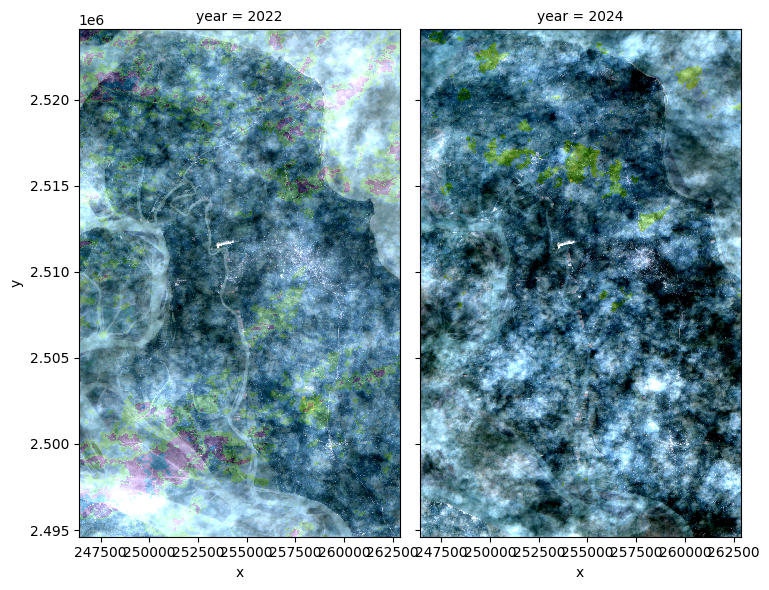

In [19]:
rgb(geomedians, col='year')

## Calculate ENDISI

The Enhanced Normalized Difference Impervious Surfaces Index (ENDISI) is a recently developed urbanisation proxy that has been shown to work well in a variety of environments ([Chen et al. 2020](https://www.tandfonline.com/doi/full/10.1080/22797254.2020.1820383)) . Like all normalised difference indicies, it has a range of \[-1,1\].
Note that `MNDWI`, `swir_diff` and `alpha` are all part of the ENDISI calculation.

$$
\begin{aligned}
\text{MNDWI} = \frac{\text{GREEN} - \text{SWIR1}}{\text{GREEN} + \text{SWIR1}}
\end{aligned}
$$

$$
\begin{aligned}
\text{swir_diff} = \frac{\text{SWIR1}}{\text{SWIR2}}
\end{aligned}
$$

$$
\begin{aligned}
\text{alpha} = \frac{2 * \text{mean(BLUE)}}{\text{mean(swir_diff) + mean(MNDWI}^2)}
\end{aligned}
$$

$$
\begin{aligned}
\text{ENDISI} = \frac{\text{BLUE} - \text{alpha}*(\text{swir_diff} + \text{MNDWI}^2)}
{\text{BLUE} + \text{alpha}*(\text{swir_diff} + \text{MNDWI}^2)}
\end{aligned}
$$

ENDISI calculations are built into the `calculate_indices` function. We are using the Sentinel-2 geomedian, so the `satellite_mission` will be `s2`.

In [22]:
# Calculate the ENDISI index
geomedians = calculate_indices(geomedians, index='ENDISI', satellite_mission='s2')

Let's plot the ENDISI images so we can see if the urban areas are distinguishable

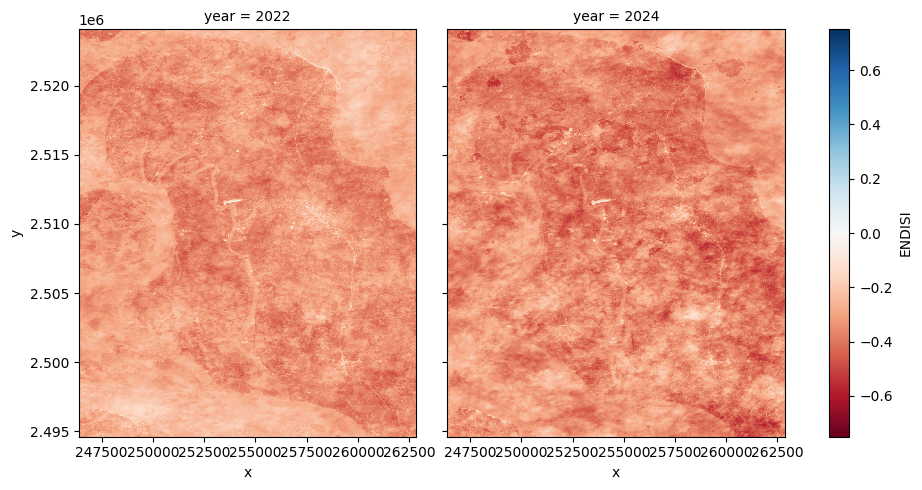

In [23]:
geomedians.ENDISI.plot(
    col='year',
    vmin=-.75, 
    vmax=0.75, 
    cmap='RdBu',
    figsize=(10, 5),
    robust=True
);

And now plot the histogram of all the pixels in the ENDISI array

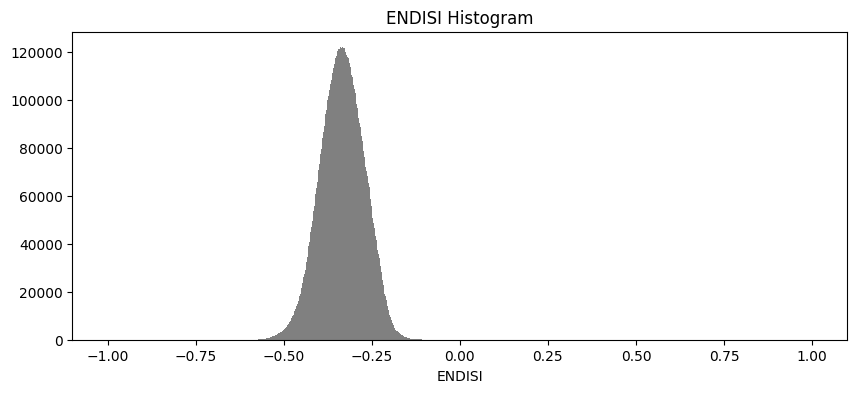

In [24]:
geomedians.ENDISI.plot.hist(bins=1000, range=(-1,1), facecolor='gray', figsize=(10, 4))
plt.title('ENDISI Histogram');

## Calculate urban extent

To define the urban extent, we need to threshold the ENDISI arrays. Values above this threshold will be labelled as 'Urban' while values below the trhehsold will be excluded from the urban extent.  We can determine this threshold a number of ways (inluding by simply manually definining it e.g. `threshold=-0.1`).  Below, we use the [Otsu method](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_thresholding.html) to automatically threshold the image.  

Firstly, we need to fill any `NaN` values we have in the dataset with the mean of the dataset, otherwise the otsu threshold function will complain:

In [25]:
geomedians['ENDISI'] = geomedians.ENDISI.fillna(geomedians.ENDISI.mean().values)

In [26]:
from skimage.filters import threshold_otsu

threshold = threshold_otsu(geomedians.ENDISI.values)
print(round(threshold, 2))

-0.34


### Apply the threshold

We apply the threshold and plot both years side-by-side.

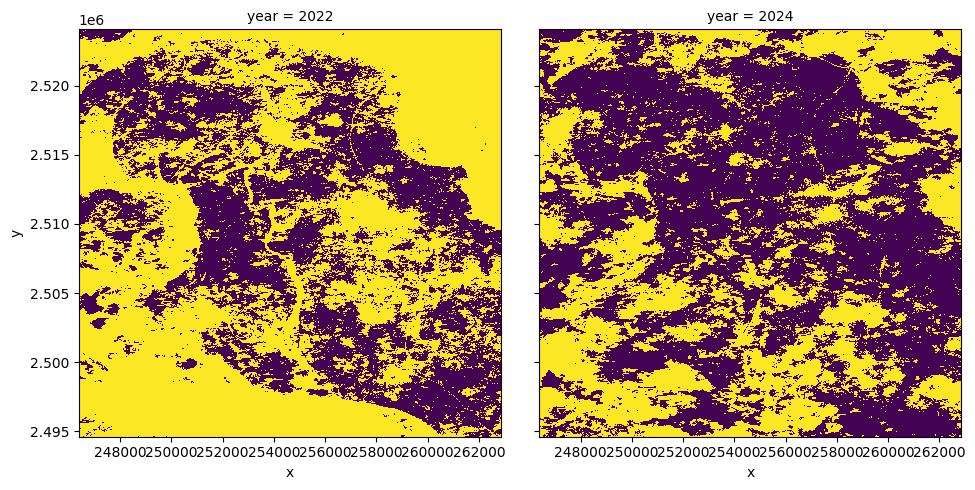

In [27]:
urban_area = (geomedians.ENDISI > threshold).astype(int)
urban_area.plot(
    col='year',
    figsize=(10, 5),
    robust=True,
    add_colorbar=False
);

## Plotting the change in urban extent
We can convert the data above into a total area for each year, then plot a bar graph.

Urban extent in 2022: 300.854 km2
Urban extent in 2024: 193.539 km2


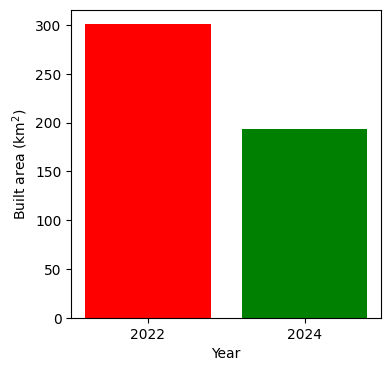

In [28]:
pixel_length = query["resolution"][1]  # in metres
area_per_pixel = pixel_length**2 / 1000**2

urban_area_km2 = urban_area.sum(dim=['x', 'y']) * area_per_pixel

# Plot the resulting area through time
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
plt.bar([0, 1], 
        urban_area_km2, 
        tick_label=urban_area_km2.year, 
        width = 0.8, 
        color=['red', 'green']
       )
axes.set_xlabel("Year")
axes.set_ylabel("Built area (km$^2$)");

for y in urban_area_km2.year.values:
    print('Urban extent in '+str(y)+": "+str(round(float(urban_area_km2.sel(year=y).values),3))+' km2')


## Urban growth hotspots

If we subtract the ENDISI of the baseline year from the analysis year, we can highlight regions where urban growth is occurring. 

In this plot, we can see areas that have seen significant change, highlighting regions of urbanisation. 

In [35]:
# Calculate the change between the years

analysis_year
baseline_year

urban_change = urban_area.sel(
    year=2024) - urban_area.sel(year=2022)

urban_change

urban_growth = urban_change.where(urban_change == 1)
urban_decline = urban_change.where(urban_change == -1)

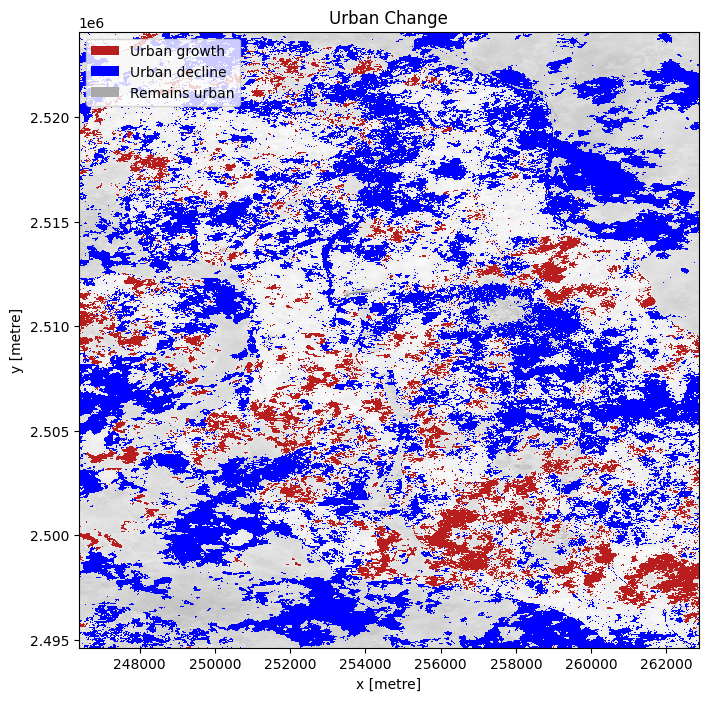

In [36]:
urban_appeared = '#b91e1e'
urban_disappeared = 'Blue'

# Plot urban extent from first year in grey as a background
plot = geomedians.ENDISI.sel(year=baseline_year).plot(size=8,
                                                      aspect=urban_area.y.size /
                                                      urban_area.y.size,
                                               cmap='Greys',
                                               add_colorbar=False)

# add urban growth and decline to the plot
urban_growth.plot(ax=plot.axes,
                  cmap=ListedColormap([urban_appeared]),
                  add_colorbar=False,
                  add_labels=False,
                  )
urban_decline.plot(ax=plot.axes,
                   cmap=ListedColormap([urban_disappeared]),
                   add_colorbar=False,
                   add_labels=False
                   )
# Add the legend
plot.axes.legend(
    [
        Patch(facecolor=urban_appeared),
        Patch(facecolor=urban_disappeared),
        Patch(facecolor='darkgrey'),
        Patch(facecolor='white')
    ],
    ['Urban growth', 'Urban decline', 'Remains urban'],
    loc='upper left'
)

plt.title('Urban Change');

## Next steps

When you are done, return to the [Analysis parameters](#Analysis-parameters) section, modify some values (e.g. `lat`, `lon` or `time`) and rerun the analysis.

You can use the interactive map in the [View the selected location](#View-the-selected-location) section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

If you're going to change the location, you'll need to make sure Landsat 8 data is available for the new location, which you can check at the [Digital Earth Africa Explorer](https://explorer.digitalearth.africa/products/ls8_sr).


For more advanced methods of urban extent detection, see the [Machine Learning with ODC](../Real_world_examples/Machine_learning_with_ODC.ipynb) notebook, which uses a decision tree to classify urban area. 

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [18]:
print(datacube.__version__)

1.8.15


**Last Tested:**

In [19]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-08-14'